# Gerador de dados sísmicos paralelizado

## Imports e configurações 

In [16]:
from time import time
from joblib import Parallel, delayed
from scipy.signal import convolve2d
from tqdm import tqdm
from utils import * 

import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os
import shutil

In [2]:
path_save = './../Code_Pix2Pix/datasets/seismic_e2'
delete_existing_samples = True

## Utils

In [3]:
class ImageUtil:
    @staticmethod
    def show_img(img, color='gray', show_axis=False):
        fig, ax = plt.subplots()
        if not show_axis: ax.axis("off")
        ax.imshow(img, cmap=color)
        # fig.set_size_inches(int(img.shape[0] / 4), int(img.shape[1]/4))
        fig.show()

    
    @staticmethod
    def open_image(path, color_code=cv2.COLOR_BGR2RGB):
        return cv2.cvtColor(cv2.imread(path), color_code) 

    
    @staticmethod
    def save_img(img, path, norm=False, color='seismic'):
        if norm:
            vmin, vmax = img.min(), img.max() 
            img = (img - vmin) / (vmax - vmin)
            cv2.imwrite(name, img * 255)
        else:
            plt.imsave(path, img, cmap=color, vmin=-img.max(), vmax=img.max())

## PSFs e Ricker

###### Carregando as PSFs

Dados carregados de ./janelas/jequitinhonha.pickle
 - scatter_widths
 - frequencies
 - scatters
Visualizando '' - 6 amostras


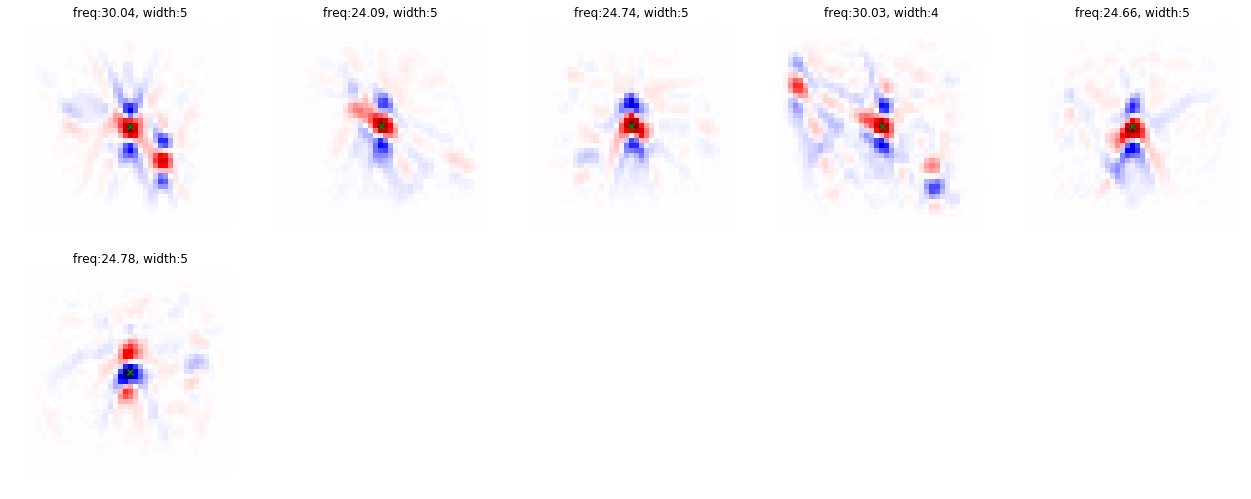

In [4]:
# Arquivo com PSFs
psf_file = './janelas/jequitinhonha.pickle'

data_dic = load_pickle(psf_file)
scatters = data_dic['scatters']
frequencies = data_dic['frequencies']
scatter_widths = data_dic['scatter_widths']

# Visualiza PSFs importados
max_samples = 30
color='seismic'
resize=3.5

# Cria título informativo para cada janela
labels = ['freq:%.2f, width:%d' % (f,w) for f,w in zip(frequencies, scatter_widths)]

if max_samples < scatters.shape[0]:
    num_samples = max_samples
else:
    num_samples = None
    
view_samples(scatters, labels, num_samples=num_samples, resize=resize, color=color)

###### Função que retorna uma das PSFs carregadas

In [5]:
def get_random_psf(return_infos=False):
    # Seleciona um PSF para convolver com o dado de estruturas
    psf_index = random.randint(0, len(scatters)-1)
    
    psf = scatters[psf_index]
    psf_freq = frequencies[psf_index]
    psf_width = scatter_widths[psf_index]

    title = 'freq:%.2f, width:%d' % (psf_freq, psf_width)
    
    if return_infos:
        return psf, psf_freq, psf_width
    else:
        return psf

###### Gerando a Wavelet de Ricker

In [6]:
psf, psf_freq, psf_width = get_random_psf(return_infos=True)
taper_size = 4
window_size = psf.shape[0]
dt = 0.004

# Constrói wavelet
wavelet = ricker_wavelet(psf_freq, window_size, dt)
# Constrói wavelet 2D
wavelet = wavelet.reshape((1,-1)).T
wavelet_2D = np.empty((window_size, taper_size*2+1), dtype=np.float32)
wavelet_2D[:,:] = wavelet
# Suaviza bordas aplicando função de taper
wavelet_2D = apply_taper(wavelet_2D, taper_size)
print("Wavelet_2D", wavelet_2D.shape)

def get_ricker():
    return wavelet_2D 

Wavelet_2D (41, 9)


###### Mostrando um exemplo

Tamanho da imagem (em polegadas): 5.69 x 5.69
Coordenadas:  x - [0.0, 41.0], y - [0.0, 0.2]
Dimensão: (41, 41)



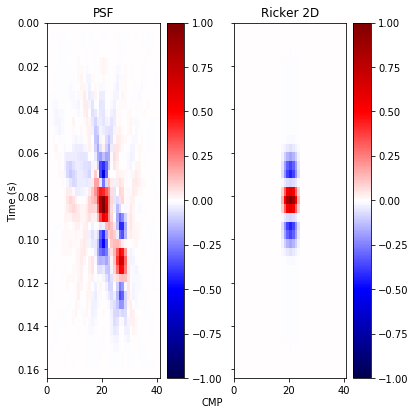

In [7]:
# Constrói janela para visualização equivalente ao PSF
color='seismic'
resize=10.0

title1='PSF'
title2='Ricker 2D'
    
center = int(window_size/2)  
wavelet_window = np.zeros(psf.shape)
wavelet_window[:, center-taper_size:center+(taper_size+1)] += wavelet_2D

multiple_event_viewer(psf, wavelet_window, resize=resize, color1=color, color2=color, dt=dt, title1=title1, title2=title2)

## Gerador do dataset

###### Função para gerar exemplos com retas

In [8]:
def make_sample_retas(psf, wavelet_2D):
    img_ref = np.zeros((256, 256))
    n_retas = random.randint(10, 15)

    for i in range(n_retas):
        x = random.randint(1, 127)
        y = random.randint(1, 255)
        size = random.randint(127, 255 - x)
        reta = np.ones((1, size))
        img_ref[y, x:x+size] = reta

    noise = 0.1
    img_back = (np.random.random(img_ref.shape) - 0.5) * noise
    noisy_img_ref = img_back + img_ref

    synthetic_psf = convolve2d(noisy_img_ref, psf, mode='same')
    synthetic_ricker2D = convolve2d(noisy_img_ref, wavelet_2D, mode='same')

    return synthetic_psf, synthetic_ricker2D

###### Função para gerar exemplos com curva

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until


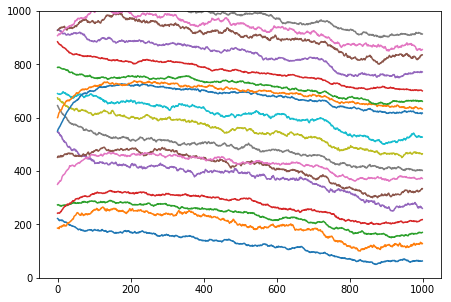

In [42]:
def plot_to_numpy(fig):
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data


def make_sample_curves(): # psf, wavelet_2D):
    num_steps = 1000
    num_sections = 2
    theta_end = (2*np.pi)*0.4

    sections = np.empty(num_sections+1, dtype=np.int)
    sections[0] = 0
    sections[-1] = num_steps
    if num_sections > 1:
        sections[1:-1] = np.sort(np.random.choice(np.arange(int(num_steps*0.05),int(num_steps*0.95)),
                                                  (num_sections-1),replace=False))

    count = 0
    phase = np.random.random()*(2*np.pi)
    theta = np.empty(num_steps, dtype=np.float32)
    for begin,end in zip(sections[:-1],sections[1:]):
        theta[begin:end] = 2**count
        count+=1

    theta = np.arange(0,theta_end,theta_end/num_steps) + theta + phase
    chaos = np.cos(theta) + np.sin(theta)
    beta = 0.98
    
    fig = plt.figure()
    ax = fig.gca()
    fig.tight_layout(pad=0)

    for offset in range(50, 950, 50):
        sigma = np.random.rand() + 1.0
        random_walk = np.empty(num_steps, dtype=np.float32)
        step = (np.random.random() - 0.5) * 8
        for i in range(num_steps):
            random_walk[i] = step
            step = (1-beta)*np.random.normal(loc=chaos[i], scale=sigma) + beta*step
        random_walk -= random_walk.min()

        scale = np.random.rand() * 30 + 30
        reflective_curve = np.round((random_walk*scale) + offset)

        ax.plot(range(num_steps), reflective_curve)

    plt.ylim((0, num_steps))
    data = plot_to_numpy(fig)
    # ax.set_axis_off()
    # ax.autoscale(False)
    # extent = ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
    # plt.savefig('teste.jpg', bbox_inches=extent, pad_inches=-0.1)
    
    # plt.grid()
    # plt.axis('off')
    # plt.show()
    # plt.savefig("./" + pre_path + "/" + names[i] + '_' + str(index) + '.jpg', bbox_inches='tight', pad_inches=-0.2)
    # plt.savefig('teste.jpg', bbox_inches='tight')
    # plt.cla()
    # plt.close()
    
    
make_sample_curves()

In [11]:
def process_sample(path, i):
    if (i + 1) % 500 == 0: print("Gerados: ", i - 1)
    x, y = make_sample_retas(get_random_psf(), get_ricker())
    img = np.append(x, y, axis=1)
    ImageUtil.save_img(img, path + "/" + str(i) + ".jpg")

def create_dataset(n_samples, pre_path=path_save):
    start_time = time()
    
    if not os.path.exists(path_save): 
        os.mkdir(path_save)
    elif delete_existing_samples:
        shutil.rmtree(path_save, ignore_errors=True)
        os.mkdir(path_save)
    
    folders = ["train", "val", "test"]
    list_n_samples = [n_samples, int(n_samples * 0.2), int(n_samples * 0.2)]
    nc = mp.cpu_count()
    print("Cpu count: ", nc)
    
    for j in range(3):
        print("Generating: ", folders[j])
        path = pre_path + "/" + folders[j]
        if not os.path.exists(path):
            os.mkdir(path)
        Parallel(n_jobs=nc)(delayed(process_sample) (path, i) for i in tqdm(range(list_n_samples[j])))
    
    print("Time: ", time() - start_time)

In [12]:
create_dataset(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Cpu count:  8
Generating:  train


  0%|          | 0/200 [00:00<?, ?it/s]

Generating:  val


  0%|          | 0/200 [00:00<?, ?it/s]

Generating:  test


100%|██████████| 200/200 [00:19<00:00, 10.51it/s]


Time:  141.09430122375488
